In [27]:
import matplotlib.pyplot as plt
import matplotlib.transforms
import matplotlib.path
import numpy as np
import pickle
import matplotlib.animation as animation
from matplotlib import gridspec
from matplotlib.collections import LineCollection
from my_tools import *
plt.rcParams.update({'font.size': 17})

def rainbowarrow(ax, start, end, cmap="viridis", n=50,lw=3):
    cmap = plt.get_cmap(cmap,n)
    # Arrow shaft: LineCollection
    x = np.linspace(start[0],end[0],n)
    y = np.linspace(start[1],end[1],n)
    points = np.array([x,y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw)
    lc.set_array(np.linspace(0,1,n))
    
    ax.add_collection(lc)
    # Arrow head: Triangle
    tricoords = [(0,-0.4),(0.5,0),(0,0.4),(0,-0.4)]
    angle = np.arctan2(end[1]-start[1],end[0]-start[0])
    rot = matplotlib.transforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = matplotlib.path.Path(tricoords2, closed=True)
    ax.scatter(end[0],end[1], c=1, s=(2*lw)**2, marker=tri, cmap=cmap,vmin=0)
    #ax.autoscale_view()
    

In [28]:
def unpickle(where_pkl):
    with open(where_pkl, 'rb') as f:
        return pickle.load(f)
    
class Patient:
    def __init__(self, plot_path,assessment_path,baseline_file,files_to_remove,vta_path):
        self.plot_path = plot_path
        self.assessment_path = assessment_path
        self.baseline_file = baseline_file
        self.files_to_remove = files_to_remove
        self.vta_path = vta_path
        
    def pickle(self, where_pkl):
        pickleFile = open(where_pkl, 'wb')
        pickle.dump(self, pickleFile)
        pickleFile.close()
   

In [32]:
def plot_assessment(day_assessment,df,ax,side,loaded_stimulation_dicts,destination_figure):
    data = df[df['date'] <= day_assessment]
    # we want to plot the evolution of these metrics in time
    # for dates still to follow, we want to leave an empty space
    # we therefore build an empty fake df for the future dates
    rest = pd.unique(df[df['date'] > day_assessment]['date'])
    missing_df = pd.DataFrame([[missing_date, np.nan, np.nan] for missing_date in rest], columns=df.columns)
    data = data.append(missing_df)

    ax.clear()
    # fig, ax = plt.subplots(figsize=(12,8))
    for m in pd.unique(data['measure']):
        if m == m:  # means the measure is not null

            portion_measure = data[(data['measure'] == m) | (data['measure'] != data['measure'])].sort_values(
                by=['date'])

            index = [pd.to_datetime(str(day)).strftime("%d.%m.%y") for day in portion_measure.date.values]
            index[0] = 'Baseline'
            if m == 'SOFAS':
                portion_measure.value = 100 - portion_measure.value

            if pd.to_datetime(day_assessment).strftime("%d.%m.%Y") not in [el['date'] for el in loaded_stimulation_dicts]:
                intensity = 'Baseline'
            else:
                intensity = [el['stimulation'][side]['amplitude'] for el in loaded_stimulation_dicts if
                             el['date'] == pd.to_datetime(day_assessment).strftime("%d.%m.%Y")][0]
            x = np.arange(len(index))
            ax.set_xlim(right = len(index))
            ax.set_ylim([0, 100])

            # create axes with dates along the x axis
            ax.set(xticks=x, xticklabels=index, yticks = [0,20,40,60,80,100])
            ax.tick_params(axis='x', labelrotation=90)
            ax.set_xlabel('Session date')
            ax.set_ylabel('% depression scales')
            ax.set_title('Depression assessment evolution', fontsize=22, fontweight="bold")
            #
            ax.plot(x, portion_measure['value'], label=m)
            ax.legend(title='Depression scales', loc='center right', bbox_to_anchor=(1.30, 0.5), fancybox=True,
                      shadow=True)
            ax.xaxis.grid(True, color='gray', linestyle='--')

            ax.text(1.22, 0.9, pd.to_datetime(day_assessment).strftime("%d.%m.%y"), transform=ax.transAxes, size=30,
                    ha='right')
            ax.text(1.15, 0.7, intensity, transform=ax.transAxes, size=24, ha='right')
            ax.xaxis.labelpad = 20
            #plt.tight_layout()


    return

In [33]:
Pat1 = unpickle('Pat1.pkl')

10.09.2018 has nan LEFT stimulation
10.09.2018 has nan ROIGHT stimulation
10.09.2018 has nan LEFT stimulation
10.09.2018 has nan ROIGHT stimulation
14.09.2018 has nan LEFT stimulation
14.09.2018 has nan ROIGHT stimulation


[]

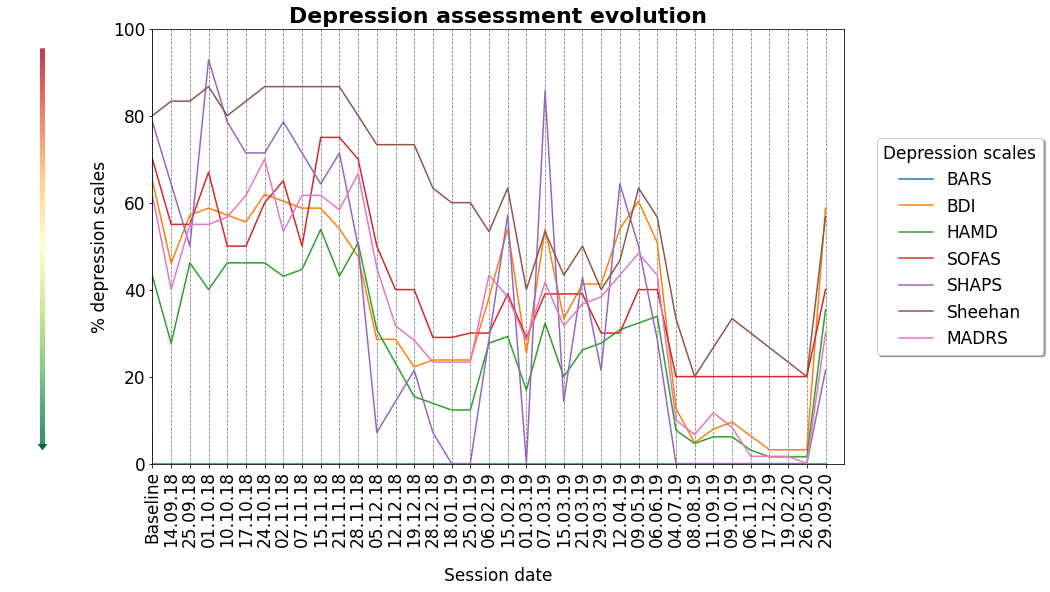

In [37]:
#MAIN - with arrow

loaded_stimulation_dicts = np.load(Pat1.assessment_path + '/corrected_stimulations.npy', allow_pickle='TRUE')

dates = np.load(Pat1.plot_path + '/sorted_dates.npy')

# the .npy files has the dates in the format "%d/%m/%Y"
# while the original excel assessment files follow "%d.%m.%Y"


list_of_assessments = ['BDI', 'HAMD', 'MADRS', 'SHAPS', 'Sheehan', 'SOFAS', 'BARS']
max_val_assessment = dict(zip(list_of_assessments, [63, 65, 60, 14, 30, 100, 14]))  # from the summary file

df = read_assessments(dates, Pat1.assessment_path, Pat1.baseline_file, Pat1.files_to_remove)
#df.to_csv(os.path.join(Pat1.save_path, 'Depression_scales_evolution.csv'))

fig = plt.figure(figsize= (15,8))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 10], wspace=0.2)
ax0 = fig.add_subplot(spec[0])# where we will put the arrow
rainbowarrow(ax0, (0,1), (0,0), cmap="RdYlGn", n=1000,lw=5)
ax0.axis('off')

ax = fig.add_subplot(spec[1])
side = 'left' # normally left and right stimulation are identical, but one never knows
animator = animation.FuncAnimation(fig, plot_assessment, frames=pd.unique(sorted(df.date)), fargs = (df,ax,side,loaded_stimulation_dicts,'', ))

writervideo = animation.FFMpegWriter(fps=2)
#os.makedirs(Pat1.save_path, exist_ok=True)
animator.save(os.path.join('', 'Depression_scales_evolution.mp4'), writer=writervideo)

# save static figure without amplitudes
for txt in ax.texts:
    txt.set_visible(False)
 
plt.plot()